# $\mathrm{CH_3NO_3}$ (Methyl Nitrate)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3ONO2" 
nice_name = "Methyl Nitrate"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([270.0, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0  …  322.12, 322.8, 323.56, 324.4, 325.23, 326.06, 326.97, 327.88, 328.86, 329.85], [2.37e-20, 1.99e-20, 1.57e-20, 1.17e-20, 8.36e-21, 5.59e-21, 3.56e-21, 2.11e-21, 1.39e-21, 6.26e-22  …  3.92e-22, 3.72e-22, 3.48e-22, 3.28e-22, 3.08e-22, 2.9e-22, 2.73e-22, 2.57e-22, 2.42e-22, 2.28e-22], [298.0, 294.0, 298.0, 298.0, 298.0, 298.0, 298.0, 298.0, 239.0, 294.0  …  298.0, 298.0, 240.0, 260.0, 280.0, 298.0, 320.0, 340.0, 360.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  21, 21, 21, 21, 21, 21, 21, 21, 21, 21], "K", "Organics (N-compounds)", "CH3ONO2", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2291


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,285.423,190.0,286.12,345.03,0,Float64
2,σ,1.02191e-19,4.437e-24,1.06e-20,1.8e-17,0,Float64
3,T,297.85,294.0,298.0,298.0,0,Float64
4,source_id,6.63859,1,5.0,21,0,Int64


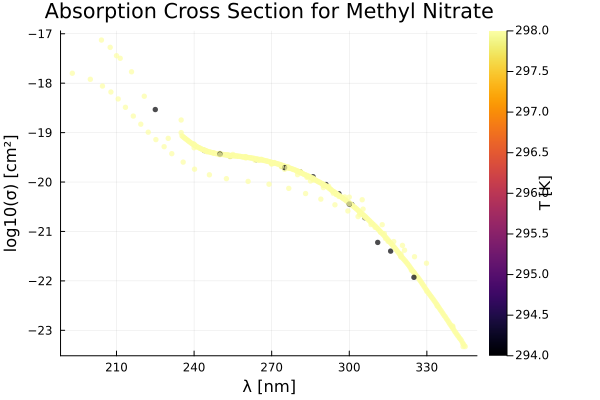

In [8]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


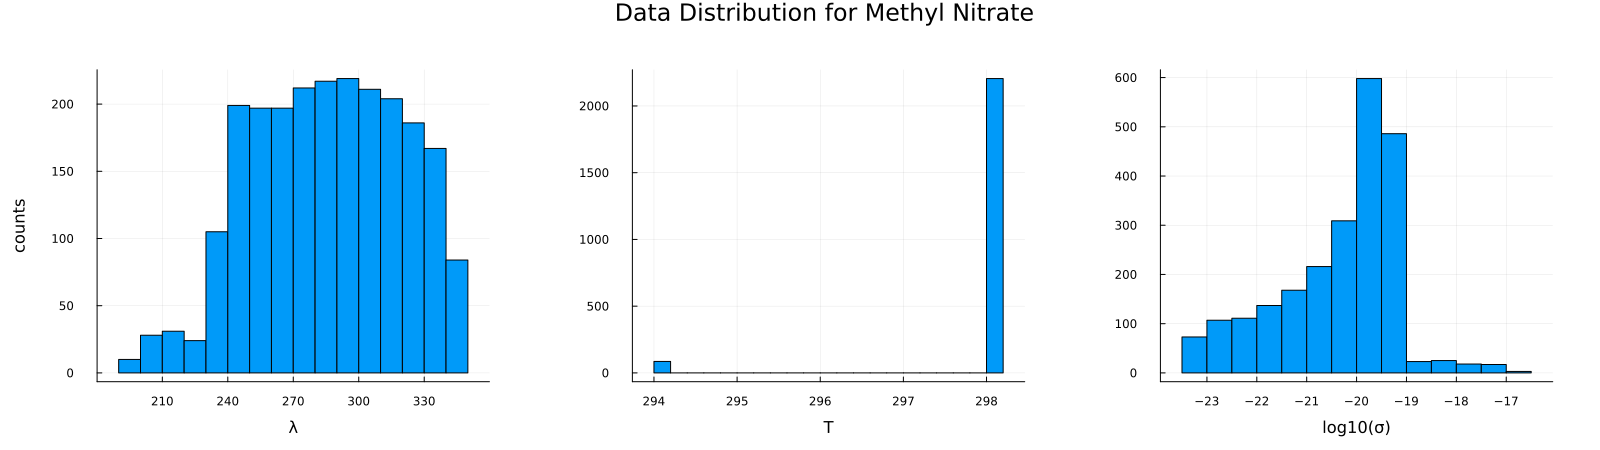

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,220.0,6.68e-19,294.0
2,225.0,2.93e-19,294.0
3,230.0,1.57e-19,294.0
4,235.0,9.0e-20,294.0
5,240.0,5.615e-20,294.0
6,242.0,4.88e-20,294.0
7,244.0,4.34e-20,294.0
8,245.0,4.07e-20,294.0
9,246.0,3.97e-20,294.0


In [13]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

# df_unique = df_unique[df_unique.T .!= 298.0, :]

2047


In [14]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(1610, 3)


190.12

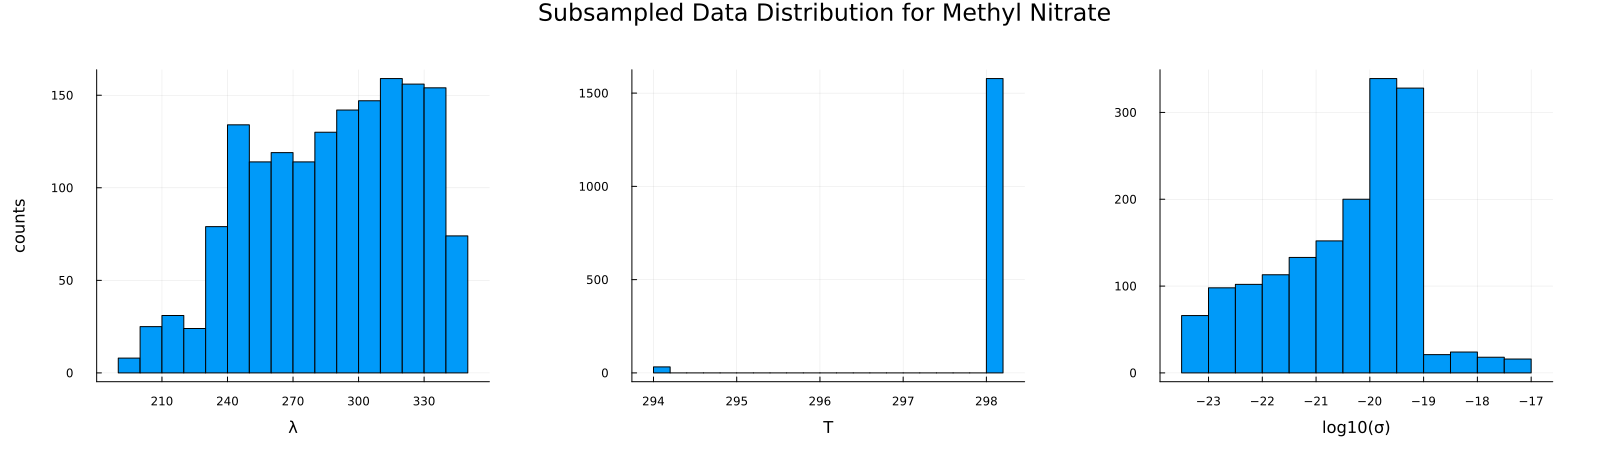

In [15]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

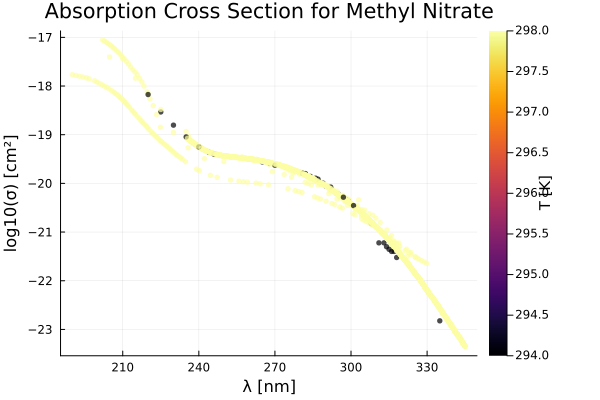

In [16]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [17]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1449


In [18]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

161-element Vector{Float64}:
 -19.319664486585438
 -19.46042211665469
 -22.970616222314792
 -18.772113295386326
 -20.366531544420415
 -19.537302591898282
 -20.2010732614228
 -22.217527375833715
 -20.40274371707486
 -19.111202932543318
 -21.985479461242075
 -20.501276029252097
 -18.739928612014925
   ⋮
 -19.328827157284916
 -22.212752119668046
 -19.367542707815275
 -19.904133546521457
 -20.376543951930067
 -19.1830299622427
 -17.079876673709276
 -19.526659035814063
 -20.484126156288323
 -19.412513534589035
 -23.26608084898761
 -21.32550628270365

In [19]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 25 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

# overwriting with recent best-fit values
θ_init = (σf²=positive(48.56890036639545), ℓ_λ=positive(21.554485274061683), ℓ_T=positive(0.6075646601330477))
σₙ² = 0.0123789728213459

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [20]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.8829834156132805, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.0705839275688187, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.4982966975244387, exp, 1.4901161193847656e-8)), 
  σ² = 0.0123789728213459, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [21]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -1.062453e+03     3.730521e+01
 * time: 0.020486116409301758
     1    -1.063713e+03     4.981709e+00
 * time: 2.334886074066162
     2    -1.063754e+03     5.226069e-01
 * time: 3.9211339950561523
     3    -1.063755e+03     5.556545e-01
 * time: 5.246007919311523
     4    -1.063773e+03     3.542373e-01
 * time: 7.135782957077026
     5    -1.063773e+03     3.865681e-03
 * time: 7.839165925979614
     6    -1.063773e+03     2.600694e-04
 * time: 8.86157512664795
     7    -1.063773e+03     1.145046e-03
 * time: 10.57388710975647
     8    -1.063773e+03     1.315770e-03
 * time: 11.253093004226685
     9    -1.063773e+03     1.001257e-03
 * time: 12.279628038406372
    10    -1.063773e+03     5.944038e-04
 * time: 13.351885080337524
    11    -1.063773e+03     1.206222e-04
 * time: 14.968312978744507
    12    -1.063773e+03     3.165714e-04
 * time: 16.333622932434082
    13    -1.063773e+03     3.189968e-04
 * time: 18.04912400245666

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @980 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @934 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [22]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.951584390269378, 3.113508237011262, -0.4974794694679151, -4.443748946152478],
 minimum = -1063.772858404909,
 iterations = 1000,
 converged = false,)

In [23]:
fp = fitted_params(mach)

(θ_best = [:σf² => 52.01771796050446, :ℓ_λ => 22.499840890983812, :ℓ_T => 0.6080613819471392],
 σ² = 0.011751813872675985,)

In [24]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


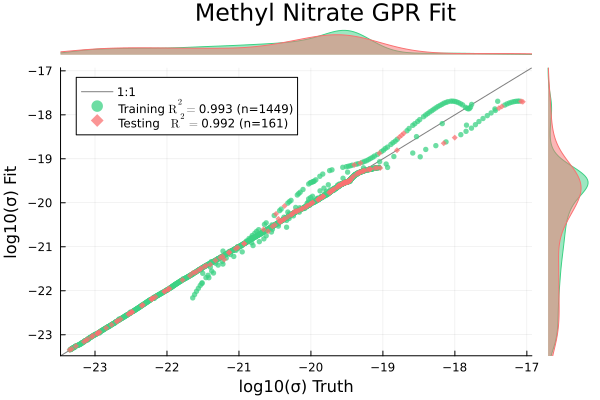

In [25]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


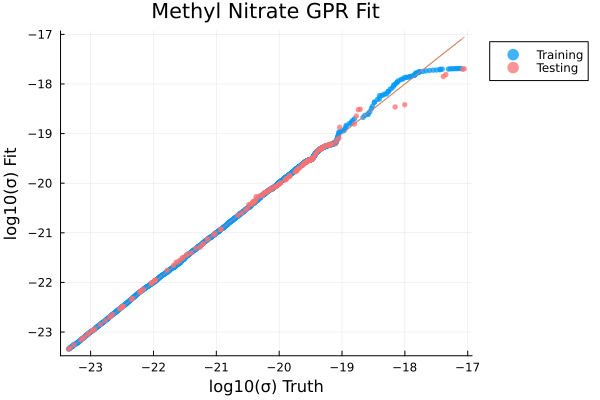

In [26]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


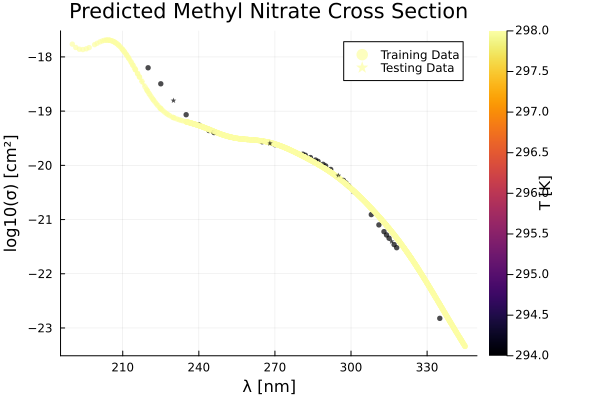

In [27]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

194.249
345.03


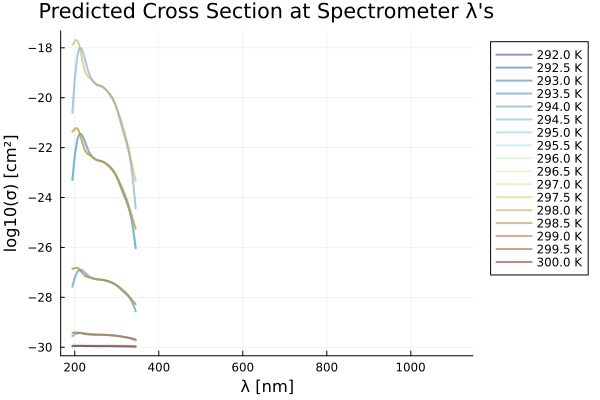

In [28]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

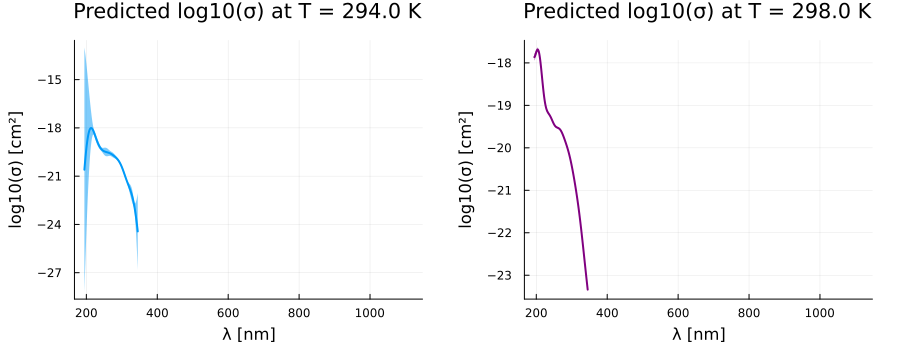

In [29]:
Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [30]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [31]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

190.12	194.249
345.03	1120.216


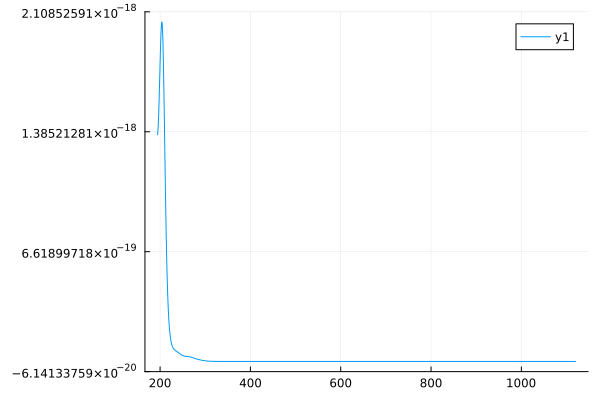

In [32]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [33]:
df_photolysis_σ.σ_51 = σ

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [34]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"